## Example for extending Mondrian Trees

In [3]:
import Base.copy
using Distributions
using MLBase
using Plots
include("./Mondrian_Forest_Classifier.jl"); 
include("Mondrian_extention.jl")

LoadError: LoadError: LoadError: [91minvalid redefinition of constant Mondrian_Node[39m
while loading /home/annika/RSG Julia/warwick-rsg/MondrianForest/Mondrian_Tree.jl, in expression starting on line 9
while loading /home/annika/RSG Julia/warwick-rsg/MondrianForest/Mondrian_Forest_Classifier.jl, in expression starting on line 1

This notebook explains how to extend Mondrian Trees and Mondrian Forests. Using an online algorithm, we can incorporate data points one by one.

### Functions

All functions used in this section can be found in the files "Mondrian_extention.jl" and "Mondrian_extention_utils.jl". 

In [2]:
?Extend_Mondrian_Tree!

search:



`function Extend_Mondrian_Tree!(T::Mondrian_Tree,λ::Float64,X::Array{Float64} where N,Y::Int64)`

This function extends an already existing Mondrian Tree by ONE new datapoint that gets incorperated in the tree. 

`Input`: Mondrian Tree T (abstract type Mondrian_Tree), Lifetime parameter λ (Float64), 1dim Array of Features Array X (Array of Float64), classlabel Y (Int64)

`Output`: Mondrian Tree

`Files needed to run this function`: "Mondrian_Forest_Classifier.jl", "Mondrian_extention.jl"

This function calls the function Extend_Mondrian_Block.

The usage of the function "expand!" is recommended to expand Mondrian Trees as it has a nicer user interface.


In [3]:
?Extend_Mondrian_Tree!

search:



`function Extend_Mondrian_Tree!(T::Mondrian_Tree,λ::Float64,X::Array{Float64} where N,Y::Int64)`

This function extends an already existing Mondrian Tree by ONE new datapoint that gets incorperated in the tree. 

`Input`: Mondrian Tree T (abstract type Mondrian_Tree), Lifetime parameter λ (Float64), 1dim Array of Features Array X (Array of Float64), classlabel Y (Int64)

`Output`: Mondrian Tree

`Files needed to run this function`: "Mondrian_Forest_Classifier.jl", "Mondrian_extention.jl"

This function calls the function Extend_Mondrian_Block.

The usage of the function "expand!" is recommended to expand Mondrian Trees as it has a nicer user interface.


In [4]:
?expand!

search: expand expanduser macroexpand @macroexpand



`function expand!(T::Mondrian_Tree_Classifier,X::Array{Float64,N} where N,Y::Array{Int64},λ::Float64)`

This function expands an already sampled Mondrian Tree Classifier by a desired number of datapoints. 

`Input`: Mondrian Tree Classifier T (abstract type Mondrian_Tree_Classifier), array of features X (Array of Float64), array of class labels (1dim of Float 64), Lifetime parameter λ (Float 64)

Each row in the array X represents one set of features, the corresponding row in Y represents the class label. 

`Output`: Mondrian Tree Classifier with incoporated new datapoints

`Files needed to run this function`: Mondrian_Forest_Classifier.jl", "Mondrian_extention.jl"

This function calls the function Extend_Mondrian_Tree. 


In [5]:
?expand_forest!

search:



`function expand_forest!(MF::Mondrian_Forest_Classifier,X_extend, Y_extend,λ)`

This function expands an already sampled Mondrian Forest Classifier by a desired number of datapoints.

`Input`: Mondrian Forest Classifier MF (abstract type Mondrian_Forest_Classifier), array of features X_extend to extend the forest on, Array of class labels Y_extend corresponding to the new features, life time parameter λ

`Output`: Mondrian Forest Classifier with incoporated new datapoints

`Files needed to run this function`: Mondrian_Forest_Classifier.jl", "Mondrian_extention.jl"

This function calls the function expand!. 


#### 1) Prepare some data

We generate two sets of fakedata (features + classes). We use the first one to train on and the second one to extend on.

In [2]:
function Fakedata3Classif(N,d,N_test=0)
    X = randn((N,d))
    param1 = randn(d)
    param2 = randn(d)
    Y = ( sum(X*param1,2) .> mean(sum(X*param2,2)) )
    Y=convert(Array{Int},Y)
    for i in 1:size(X,1)
        if X[i,2] > 1.5
            Y[i] = 3
        end
    end
    if (N_test > 0)
        x = randn((N_test,d))
        y = ( sum(x*param1,2) .> mean(sum(x*param2,2)) )
        y=convert(Array{Int},y)
        for i in 1:size(x,1)
            if x[i,2] > 1.5
                y[i] = 3
            end
        end
        return X,Y,x,y
    end
    return X,Y
end

Fakedata3Classif (generic function with 2 methods)

In [7]:
X, Y, x, y = Fakedata3Classif(5000,2,5000);  #X,Y: train set ; x,y: extention data
Y = Y.+1;
y = y.+1;

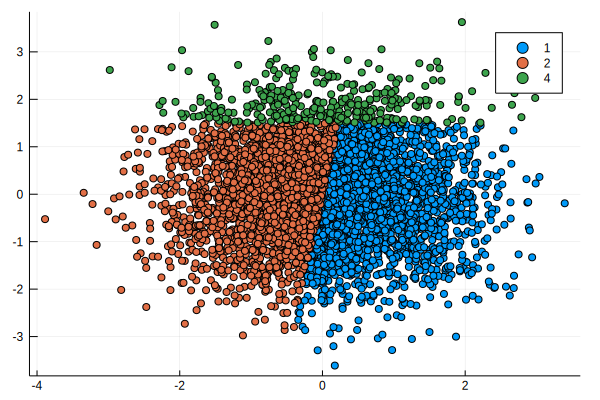

In [8]:
if size(X,2)==2
    plot()
    for class in unique(Y)
        scatter!(X[Y.==class,1],X[Y.==class,2],label="$class")
    end
    plot!()
end

### 1) Extend a single tree

To extend a single tree, we can just use the function expand!. We train a Mondrian Tree Classifier on the dataset X,Y and then extend it on the dataset x,y which we created above. We compute the training accuracy of the extended tree. For comparison, we then train a Mondrian Tree Classifier on the merges dataset X,x Y,y (it was then trained on all of the data the extended tree was trained on, without using extentions) and compute the training accuracy as well.  

In [9]:
T = Mondrian_Tree_Classifier()
train!(T,X,Y,1e9);  #Sample tree on training dataset

In [10]:
expand!(T,x,y,1e9);  #Expand the tree on the extention dataset

In [11]:
#merge training and extention data to get the total data the tree was trained on

All_data=vcat(X,x);             
all_labels = vcat(Y,y);

In [12]:
#let the extended tree predict the training data, compute training accuracy
pred=predict!(T,All_data);     
println("Train Accuracy of extended tree")
println(correctrate(all_labels,convert(Array{Int,1},pred)))

Train Accuracy of extended tree
0.9195


In [13]:
#compute a tree on the merged dataset (classic, no extention)
T_full = Mondrian_Tree_Classifier()
train!(T_full,All_data,all_labels,1e9);

In [14]:
#let the extended tree predict the training data, compute training accuracy

println("Train Accuracy tree trained on whole dataset")
pred=predict!(T_full,All_data)
println(correctrate(all_labels,convert(Array{Int,1},pred)))

Train Accuracy tree trained on whole dataset
0.9184


We see that the training accuracy is comparable weather we extend the tree or weather we sample the tree on the whole dataset immediatly. This proves that the extention implementation works.

### 2) Extend Mondrian Forests

Now we extend a Mondrian Forest classifier that was pretrained on the  training same dataset (X,Y) as above. We again extend the classifier and then train a new classifier on the whole datset for comparison.

In [15]:
MF = Mondrian_Forest_Classifier(50)  #initialise Mondrian Forest Classifier with 50 Trees

Mondrian Forest Classifier with 50 Mondrian trees:


In [16]:
train!(MF, X, Y, 1e9);  #Train the classifier on the same dataset as before

In [17]:
expand_forest!(MF,x,y,1e9);  #expand the forest on the dataset x,y

In [18]:
MF_control = Mondrian_Forest_Classifier(50)   #initialise control classifier with 50 Trees
train!(MF_control, All_data, all_labels, 1e9);  # train control classifier on merged dataset

In [89]:
#compute train accuracy for extended forest

pred=predict!(MF, All_data);
println("Train Accuracy")
println(correctrate(all_labels,convert(Array{Int,1},pred)))

Train Accuracy
0.794


In [19]:
#compute train accuracy for classic forest

pred = predict!(MF_control,All_data);
println("Train Accuracy")
println(correctrate(all_labels,convert(Array{Int,1},pred)))

Train Accuracy
0.9277


#### Some Testing and Benchmarking

How fast is the extention? 